In [1]:
import os
os.environ["THEANO_FLAGS"] = "device=gpu1"
from lasagne.generative.autoencoder import Autoencoder, greedy_learn_with_validation
from lasagne.easy import BatchOptimizer, LightweightModel
from lasagne.datasets.mnist import MNIST
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from lasagne import layers, updates, init, nonlinearities
import theano.tensor as T
from theano.sandbox import rng_mrg
import theano
import matplotlib.pyplot as plt
import numpy as np
from lasagne.layers import get_all_layers

import numpy as np
from skimage.io import imread
from skimage.filter import threshold_otsu
import matplotlib.pyplot as plt
from lasagne import easy
from skimage.transform import resize
from lasagne.datasets.mnist import MNIST
from lasagne.generative.capsule import Capsule
from lasagne.easy import BatchIterator
import glob
import os

from lasagne.easy import BatchOptimizer, LightweightModel
from lasagne import init
from collections import OrderedDict
from lasagne import init, layers, updates, nonlinearities
from lasagne.layers.helper import get_all_layers
from lasagne.layers import helper
import theano.tensor as T
from theano.sandbox import rng_mrg
from sklearn.cross_validation import train_test_split
from lasagne.datasets.fonts import Fonts
import theano
from collections import OrderedDict
import theano.tensor as T


%matplotlib inline

def binarize(X):
    X_b = np.empty(X.shape, dtype=X.dtype)
    for i in range(X.shape[0]):
        X_b[i] = 1. * (X[i] <= threshold_otsu(X[i]))
    return X_b

def resize_all(X, w, h):
    if X.shape[1] == w and X.shape[2] == h:
        return X
    X_b = np.empty((X.shape[0], w, h), dtype=X.dtype)
    for i in range(X.shape[0]):
        X_b[i] = resize(X[i], (w, h))
    return X_b    

%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 1: Tesla K20m


# Load & pre-process data

In [2]:
data = MNIST()
data.load()
X = data.X
X = X.astype(np.float32)
y = data.y.astype(np.int32)

In [3]:
w, h = 28, 28

In [4]:
from skimage.filter import threshold_otsu
from skimage.transform import resize
X_b = np.zeros((X.shape[0], w, h))
for i in range(X_b.shape[0]):
    X_b[i] = resize(X[i].reshape((28, 28)), (w, h))
X = X_b
X = X <= threshold_otsu(X)
X = X.astype(np.float32)
X = 1 - X
X = X.reshape((X.shape[0], w*h))

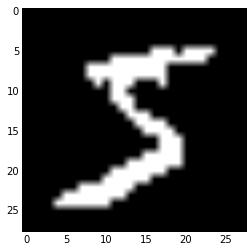

In [5]:
plt.imshow(X[0].reshape((28, 28)), cmap="gray")

In [6]:
X, y = shuffle(X, y)
train, test = train_test_split(range(X.shape[0]), test_size=0.25)

In [7]:
class MyBatchOptimizer(BatchOptimizer):
    
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        #code, = self.model.encode(X[0:100])
        #status["act_mean"] = code.mean()
        #status["act_std"] = code.std()
        #self.learning_rate.set_value(np.array(self.learning_rate.get_value() * 0.9999, dtype="float32"))
        
        s = np.arange(len(train))
        np.random.shuffle(s)
        
        s = s[0:1000]
        status["acc_train"] = (self.model.predict(X[train][s])==y[train][s]).mean()
        status["acc_valid"] = (self.model.predict(X[test][s])==y[test][s]).mean()
        
        s = np.arange(len(test))
        np.random.shuffle(s)
        s = s[0:1000]
        status["rec_train"] = self.model.get_reconstruction_error(X[train][s])
        status["rec_valid"] = self.model.get_reconstruction_error(X[test][s])
        return status

## Model definition

In [9]:
from lasagne.layers import cuda_convnet, Conv2DLayer

def cross_entropy(truth, pred):
    return -(truth * T.log(pred) + (1 - truth) * T.log(1 - pred)).sum(axis=1).mean()

def mse(truth, pred):
    return (((truth - pred) ** 2).sum(axis=1)).mean()

def loss_function_y(y_true, y_pred):
    return (T.nnet.categorical_crossentropy(y_pred, y_true)).mean()
    
def loss_representation(model):
    return
    
def build_batch_optimizer():
    #learning_rate = theano.shared(np.array(0.01, dtype="float32"))
    learning_rate = 0.001
    batch_optimizer = MyBatchOptimizer(
        verbose=1,
        max_nb_epochs=100,
        batch_size=100,
        optimization_procedure=(updates.rmsprop, 
                                {"learning_rate": 0.0001})
        
    )
    
    batch_optimizer.learning_rate = learning_rate
    return batch_optimizer


def corrupted_masking_noise(rng, x, corruption_level):
    return rng.binomial(size=x.shape, n=1, p=1 - corruption_level) * x

def corrupted_salt_and_pepper(rng, x, corruption_level):
    selected = rng.binomial(size=x.shape, n=1, p=corruption_level, dtype=theano.config.floatX)
    return x * (1 - selected) + selected * rng.binomial(size=x.shape, n=1, p=0.5, dtype=theano.config.floatX)

rng = rng_mrg.MRG_RandomStreams()
 
def corruption_function(X):
    return corrupted_salt_and_pepper(rng, X, 0.5)
    
def build_model_fully(i, o, corruption=False, batch_optimizer=None):

    if batch_optimizer is None:
        bo = build_batch_optimizer()
    else:
        bo = batch_optimizer
    
    x_in = layers.InputLayer((None, i))
    z_out = layers.DenseLayer(x_in, num_units=o,
                              nonlinearity=nonlinearities.tanh)
    x_to_z = LightweightModel([x_in], [z_out])

    z_in = layers.InputLayer((None, o))
    x_out = layers.DenseLayer(z_in, num_units=i,
                              nonlinearity=nonlinearities.tanh)
    z_to_x = LightweightModel([z_in], [x_out])
    noise_function = corruption_function if corruption is True else None
    aa = Autoencoder(x_to_z,
                     z_to_x,
                     nnet_z_to_y=z_to_y,
                     batch_optimizer=bo,
                     noise_function=noise_function,
                     #loss_function_z=loss_representation,
                     loss_function=cross_entropy_transformed)
    aa.W = z_out.W
    aa.W_inv = x_out.W
    aa.batch_optimizer.layers = [z_out]
    return aa

def build_model_cnn(i, 
                    nb_filters=32,
                    size_filters=5,
                    nb_hidden=1000,
                    nb_outputs=10,
                    corruption=False, 
                    batch_optimizer=None):
    #modèle fusion : Convnet
    #inspired from : https://github.com/mikesj-public/convolutional_autoencoder/blob/master/mnist_conv_autoencode.ipynb
    
    nb_filters_encoder = nb_filters
    nb_filters_decoder = nb_filters
    size_filters_encoder = size_filters
    size_filters_decoder = size_filters
    
    w, h = i
    
    x_in = layers.InputLayer((None, w*h))
    x_in_reshaped = layers.ReshapeLayer(x_in, ([0], 1, w, h))

    # conv1
    l_conv = cuda_convnet.Conv2DCCLayer(
        x_in_reshaped,
        num_filters=nb_filters_encoder,
        filter_size=(size_filters_encoder, size_filters_encoder),
        nonlinearity=nonlinearities.rectify,
        dimshuffle=True,
    )
    #code layer
    l_x_code = layers.DenseLayer(
        l_conv,
        num_units=nb_hidden,
        nonlinearity=nonlinearities.rectify,
    )
    
    z_out = l_x_code
    
    y_out = layers.DenseLayer(
        z_out,
        num_units=nb_outputs,
        nonlinearity=nonlinearities.softmax
    )
    
    x_to_z = LightweightModel([x_in], [z_out])

    z_in = layers.InputLayer((None, nb_hidden))
    z_to_y = LightweightModel([l_x_code], [y_out])

    # unflatten layer
    hid = layers.DenseLayer(z_in,
                            num_units=nb_filters_decoder * (w - size_filters_decoder + 1) * (h - size_filters_decoder + 1))
    hid = layers.ReshapeLayer(hid,
                              ([0], nb_filters_decoder, (w - size_filters_decoder + 1), (h - size_filters_decoder + 1)))

    l_unconv = Conv2DLayer(
        hid,
        num_filters=1,
        filter_size=(size_filters_decoder, size_filters_decoder),
        nonlinearity=nonlinearities.rectify,
        border_mode="full"
    )
    o = layers.ReshapeLayer(l_unconv, ([0], w*h))
    z_to_x = LightweightModel([z_in], [o])
    
    noise_function = corruption_function if corruption is True else None
    if batch_optimizer is None:
        bo = build_batch_optimizer()
    else:
        bo = batch_optimizer

    aa = Autoencoder(nnet_x_to_z=x_to_z,
                     nnet_z_to_x=z_to_x,
                     nnet_z_to_y=z_to_y,
                     batch_optimizer=bo,
                     noise_function=noise_function,
                     loss_function_y=loss_function_y,
                     discriminative_importance=0.5,
                     #loss_function_z=loss_representation,
                     loss_function=mse)
    #aa.W = z_out.W
    #aa.W_inv = None
    aa.batch_optimizer.layers = [z_out]
    return aa

def build_models(input_size):
    models = [
        #build_model_fully(input_size, 500, corruption=False),
        build_model_cnn((w, h), nb_filters=32, size_filters=5, nb_hidden=500)
        #build_model(500, 250),
        #build_model(250, 128),
    ]
    return models

In [10]:
models = build_models(X.shape[1])
model = models[0]

/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/init.py:91: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "
/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/misc/draw_net.py:89: UserWarning: layer.get_output_shape() is deprecated and will be removed for the first release of Lasagne. Please use layer.output_shape instead.
  'Output shape: {0}'.format(layer.get_output_shape())


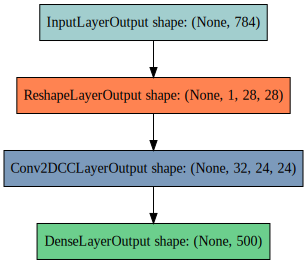

In [11]:
from lasagne.misc.draw_net import draw_to_file
draw_to_file(get_all_layers(model.nnet_x_to_z.output_layers[0]), "x_to_z.svg")
draw_to_file(get_all_layers(model.nnet_z_to_x.output_layers[0]), "z_to_x.svg")
draw_to_file(get_all_layers(model.nnet_z_to_y.output_layers[0]), "x_to_y.svg")

from IPython.display import SVG
SVG("x_to_z.svg")

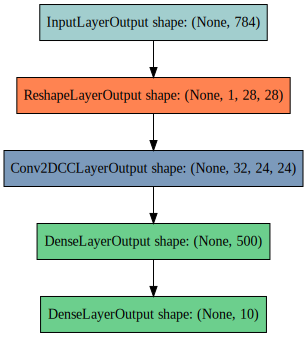

In [12]:
SVG("x_to_y.svg")

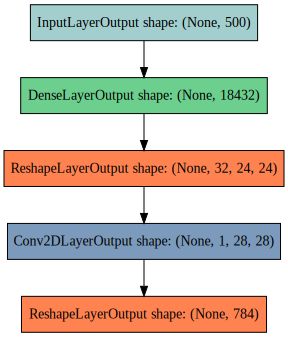

In [13]:
SVG("z_to_x.svg")

## Training 

In [14]:
model.fit(X=X[train], y=y[train])

/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/easy.py:857: UserWarning: layer.get_output(...) is deprecated and will be removed for the first release of Lasagne. Please use lasagne.layers.get_output(layer, ...) instead.
  for output_layer in self.output_layers]


IndexError: index 20524 is out of bounds for axis 0 with size 17500

In [ ]:
!nvidia-smi

In [ ]:
X_test = X[test]
r = np.arange(X_test.shape[0])
np.random.shuffle(r)
r = r[0:10]

X_hat = models[0].recover_function(X_test)
imshape = ((X_test.shape[0], w, h))

X_hat = X_hat.reshape(imshape)
X_ = X_test.reshape(imshape)
k = 0
for i in r:
    plt.subplot(len(r), 2, k + 1)
    plt.axis('off')
    plt.imshow(X_[i], cmap='gray')
    plt.subplot(len(r), 2, k + 2)
    plt.imshow(X_hat[i], cmap='gray')
    plt.axis('off')
    k += 2

In [ ]:
from lasagne.misc.plot_weights import grid_plot
layers_enc = get_all_layers(model.nnet_x_to_z.output_layers[0])
layers_dec = get_all_layers(model.nnet_z_to_x.output_layers[0])

for l in layers_enc[2], layers_dec[-2]:
    plt.clf()
    W = l.W.get_value()[:, 0]
    print(W.shape)
    grid_plot(W, imshow_options={"cmap": "gray"})
    plt.show()

In [ ]:
from lasagne.easy import get_stat

layer = 0
train_stat = get_stat("rec_train", models[layer].batch_optimizer.stats)
test_stat = get_stat("rec_valid", models[layer].batch_optimizer.stats)

plt.plot(train_stat, label="train")
plt.plot(test_stat, label="valid")
plt.xlabel("epoch")
plt.ylabel("reconstruction error")
plt.legend()
plt.title("reconstruction")
plt.show()

epoch = get_stat("epoch", models[layer].batch_optimizer.stats)
acc_train = get_stat("acc_train", models[layer].batch_optimizer.stats)
acc_valid = get_stat("acc_valid", models[layer].batch_optimizer.stats)
plt.title("accuracy")
plt.plot(acc_train, label="train")
plt.plot(acc_valid, label="valid")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.show()
